In [4]:
from google.colab import files
files.upload()


Saving dataset.zip to dataset.zip


In [5]:
import zipfile
import os

zip_file = [f for f in os.listdir() if f.endswith(".zip")][0]

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

print("Dataset folders:", os.listdir("dataset"))


Dataset folders: ['female', 'male']


In [6]:
!pip install tensorflow opencv-python pillow


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import json

IMG_SIZE = 96
BATCH_SIZE = 32
EPOCHS = 10
FINE_TUNE_EPOCHS = 5
DATASET_PATH = "dataset"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=20
)

train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)

with open("class_indices.json", "w") as f:
    json.dump(train_data.class_indices, f)

NUM_CLASSES = len(train_data.class_indices)

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    alpha=0.35
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS
)

base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(
    train_data,
    validation_data=val_data,
    epochs=FINE_TUNE_EPOCHS
)

model.save("mask_detector.keras")

print("Model trained and saved")


Found 37608 images belonging to 2 classes.
Found 9401 images belonging to 2 classes.
2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 325s 270ms/step - accuracy: 0.8046 - loss: 0.4306 - val_accuracy: 0.8653 - val_loss: 0.3176
Epoch 2/10
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 293s 249ms/step - accuracy: 0.8505 - loss: 0.3462 - val_accuracy: 0.8819 - val_loss: 0.2887
Epoch 3/10
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 302s 257ms/step - accuracy: 0.8589 - loss: 0.3318 - val_accuracy: 0.8855 - val_loss: 0.2749
Epoch 4/10
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 295s 251ms/step - accuracy: 0.8600 - loss: 0.3231 - val_accuracy: 0.8779 - val_loss: 0.2920
Epoch 5/10
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 289s 246ms/step - accuracy: 0.8643 - loss: 0.3170 - val_accuracy: 0.8918 - val_loss: 0.2725
Epoch 6/10
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 293s 249ms/step - accuracy: 0.8677 - loss: 0.3149 - val_accuracy: 0.8892 - val_loss: 0.2707
Epoch 7/10
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 292s 249ms/step - accuracy: 0.8681 - loss: 0.3123 - val_accuracy: 0.8936 - val_loss: 0.2703
Epoch 8/10
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 290s 247ms/step - ac

In [8]:
import os

for f in os.listdir():
    if f.lower().endswith((".png", ".jpg", ".jpeg")):
        os.remove(f)

print("✅ All old images deleted")


✅ All old images deleted


In [12]:
from google.colab import files
uploaded = files.upload()

img_name = list(uploaded.keys())[0]
print("📸 Using image:", img_name)


Saving 131422.jpg.jpg to 131422.jpg.jpg
📸 Using image: 131422.jpg.jpg


Label mapping: {0: 'Female', 1: 'Male'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔍 Predicted Gender: Female
📊 Confidence: 99.99%


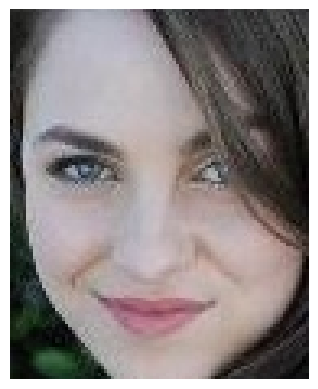

In [13]:
import cv2
import json
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load model
model = load_model("mask_detector.keras")


# Load saved class indices
with open("class_indices.json", "r") as f:
    class_indices = json.load(f)

# Reverse mapping: index → label
labels = {v: k.capitalize() for k, v in class_indices.items()}
print("Label mapping:", labels)

# Face detector
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

# Load uploaded image
pil_img = Image.open(img_name).convert("RGB")
plt.imshow(pil_img)
plt.axis("off")

img = np.array(pil_img)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)

if len(faces) == 0:
    print("❌ No face detected")
else:
    for (x, y, w, h) in faces:
        face = img[y:y+h, x:x+w]
        face = cv2.resize(face, (96,96))
        face = face / 255.0
        face = face.reshape(1,96,96,3)

        prediction = model.predict(face)
        idx = np.argmax(prediction)
        gender = labels[idx]
        confidence = prediction[0][idx] * 100

        print(f"🔍 Predicted Gender: {gender}")
        print(f"📊 Confidence: {confidence:.2f}%")
